# 1. Data Preparation and Visualization 

### 1.1 Read data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy import io as sio
#pd.set_option("display")

In [2]:
data = sio.loadmat("./ex4/ex4data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
raw_X,raw_y = data["X"], data["y"]
print(raw_X.shape,raw_y.shape)
X =np.insert(raw_X,0, values = 0, axis = 1)
print(X.shape)

(5000, 400) (5000, 1)
(5000, 401)


In [4]:
theta = sio.loadmat("./ex4/ex4weights.mat")
theta1,theta2 = theta["Theta1"],theta["Theta2"]
print(theta1.shape,theta2.shape)

(25, 401) (10, 26)


The 400 features here represents the gray scale of each pixel(400 = 20 * 20).
the first col of (25,401) is for bias unit, which requries us to add it by ourselves  

### 1.2 One hot encoding

In [5]:
def one_hot_encoder(raw_y):
    result = []  
    for i in raw_y: # loop 5000 times
        y_temp = np.zeros(10,) 
        y_temp[i-1] = 1
        result.append(y_temp)
    return np.array(result) 

In [6]:
y = one_hot_encoder(raw_y)

In [7]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

### 1.2 Serialize weight
Because scipy.minimize require 1d array so we need to flatten weight

In [8]:
def serialize(a,b):
    return np.append(a.flatten(),b.flatten())

In [9]:
theta_serialize = serialize(theta1,theta2)
theta_serialize.shape

(10285,)

### 1.3 De-serialize

In [10]:
def deserialize(theta_serialize):
    theta1 = theta_serialize[:25*401].reshape(25,401)
    theta2 = theta_serialize[25*401:].reshape(10,26)
    return theta1,theta2

# 2 Model Implementation

### 2.1 Sigmoid Function
$$h(z) = \frac{1}{(1 + e^{-z})} $$

In [11]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

### 2.2 Forward Propagation

<img src = "https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w4_neural_networks_representation/neural_network.png" height = 400, width = 500>

<img src = "https://raw.githubusercontent.com/ritchieng/machine-learning-stanford/master/w4_neural_networks_representation/neural_network2.png" height = 400, width = 500>

Given the shape of input layer is (5000,400) and there are  25 activition units in layer 1, so theta1.shape should be (400+1,25). However, the theta1 provided here is (25, 401).Thus, we need to use the transpose of theta1. Similary, we need to transpose theta2 as well.

In [12]:
def forward_propagation(theta_serialize,X):
    theta1, theta2 = deserialize(theta_serialize)
    a1 = X
    z2 = a1@ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2,0,values = 1,axis = 1,)
    z3 = a2@theta2.T
    h = sigmoid(z3)
    return a1,z2,a2,z3,h

### 2.3 Cost Function

In [13]:
def costFunc(theta_serialize, X,y):
    a1,z2,a2,z3,h = forward_propagation(theta_serialize,X)
    m=len(X)
    J = -1/m * np.sum(y*np.log(h)+(1-y)*np.log(1-h))
    return J

In [14]:
costFunc(theta_serialize, X,y)

0.30535432764413767

### 2.4 Cost Function with Regularization

In [15]:
def cost_Func(theta_serialize, X,y,Lambda):
    m = len(X)
    sum1 = np.sum(pow(theta1[:,1:],2))
    sum2 = np.sum(pow(theta2[:,1:],2))
    reg = (sum1+sum2)*Lambda/(2*len(X))
    return reg+ costFunc(theta_serialize,X,y)

In [16]:
cost_Func(theta_serialize, X,y,Lambda = 1)

0.4014950215737424

### 2.5 Gradient Descent
##### 2.5.1 Sigmoid gradient (derivative)
$$h'(z)= \frac{d}{dz}h(z)=h(z)(1-h(z))$$


In [86]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

##### 2.5.2 Gradient vector without reg

In [18]:
def gradient(theta_serialize,X,y):
    m = len(X)
    theta1,theta2 = deserialize(theta_serialize)
    a1,z2,a2,z3,h = forward_propagation(theta_serialize, X)
    d3 = h-y
    d2 = d3 @ theta2[:,1:]*sigmoid_gradient(z2)
    D2 = (d3.T @ a2) / m
    D1 = (d2.T @ a1) / m
    return serialize(D1,D2)

##### 2.5.3 Gradient vector with reg

In [49]:
def reg_gradient(theta_serialize, X,y,Lambda):
    m = len(X)
    D =gradient(theta_serialize,X,y)
    D1,D2 = deserialize(D)
    
    theta1,theta2 = deserialize(theta_serialize)
    D1[:,1:] = D1[:,1:] + theta1[:,1:] * Lambda/m
    D2[:,1:] = D2[:,1:] + theta2[:,1:] * Lambda/m
    
    return serialize(D1,D2)


##### 2.5.4 Gradient descent using TNC

In [50]:
def nn_training(X,y):
    init_theta = np.random.uniform(-0.5,0.5,10285)
    res = minimize(fun=costFunc,x0 = init_theta,
                  args = (X,y),
                  method = "TNC",
                  jac = gradient,
                  options = {"maxiter": 300})
    return res

In [51]:
res = nn_training(X,y)

C:\Users\caoli\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\caoli\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


# 3. Evaluation

##### 3.1 Using gradient without reg

In [52]:
raw_y = data["y"].reshape(5000,)
_,_,_,_,h = forward_propagation(res.x,X) #fp to get h(x)
y_pred = np.argmax(h,axis = 1) +1
acc = np.mean(y_pred == raw_y)
acc

0.9964

Since we didn't use regularzation, we have an overfitting issue. Now let's try to incorporate that.

##### 3.2 Using graident with reg

In [53]:
def nn_training_reg(X,y):
    init_theta = np.random.uniform(-0.5,0.5,10285)
    res = minimize(fun=cost_Func,x0 = init_theta,
                  args = (X,y,Lambda),
                  method = "TNC",
                  jac = reg_gradient,
                  options = {"maxiter": 300})
    return res

In [55]:
Lambda = 10
res = nn_training_reg(X,y)

In [58]:
_,_,_,_,h=forward_propagation(res.x,X)
y_pred = np.argmax(h ,axis = 1) + 1
acc= np.mean(y_pred == raw_y)
acc

0.944

Now we have addressed the overfitting issue occurred

In [84]:
def plot_hidden_layer(theta):
    theta1,_=deserialize(theta)
    hidden_layer = theta1[:,1:]
    fig,ax =plt.subplots(ncols= 5,nrows= 5, figsize= (8,8), sharex=True, sharey = True)
    
    for r in range(5):
        for c in range(5):
            ax[r,c].imshow(hidden_layer[5*r+c].reshape(20,20).T, cmap = "gray_r")
    
    plt.xticks([])
    plt.yticks([])

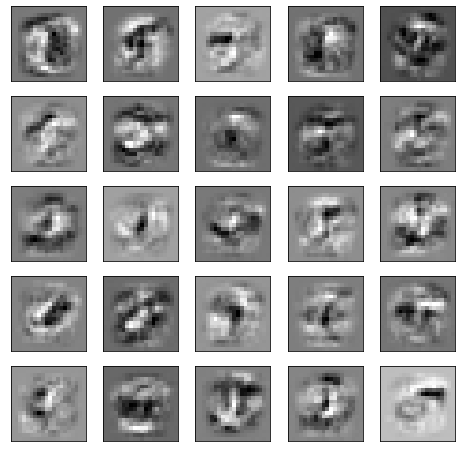

In [85]:
plot_hidden_layer(res.x)

Above is the visualzation of hidden layer. The more black a pixel is, the more importance/more helphul to it is for our model to identify the number 